In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -Uqq fastai

[Path('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca'), Path('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc'), Path('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n')]
lung_aca: 5000 images
lung_scc: 5000 images
lung_n: 5000 images
TensorCategory([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
                1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
                1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
                0])


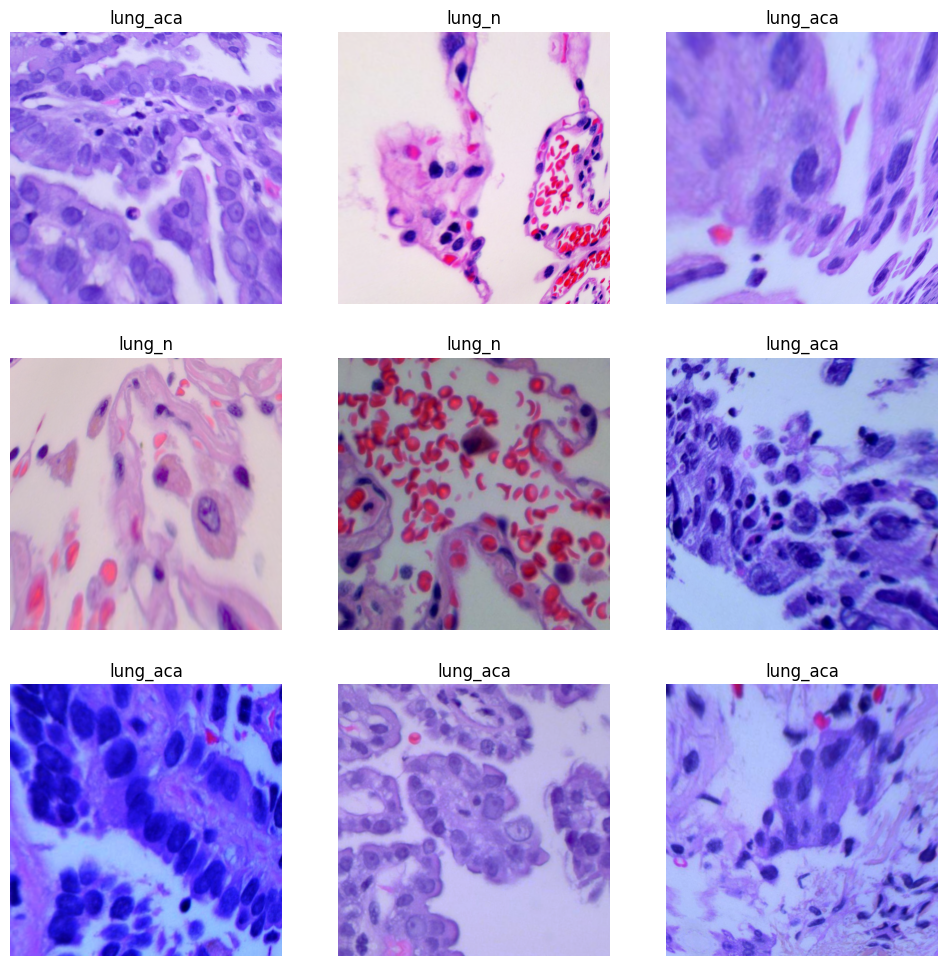

In [3]:
from fastai.vision.all import *
from pathlib import Path

path = Path('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/') #specify the path containing the folder

print(path.ls())  # This should list both 'lung_n' and 'lung_aca' directories

# Checking each class directory
for c in path.ls():
    print(f'{c.name}: {len(get_image_files(c))} images')


classes = ['lung_n', 'lung_aca'] #these act as our labels for images
np.random.seed(42)

# Function to filter and optionally subset the image files
def get_filtered_image_files(path, use_subset=True, pct=0.01):
    all_files = [x for x in get_image_files(path) if x.parent.name in classes]
    if use_subset:
        np.random.shuffle(all_files)
        return all_files[:int(len(all_files) * pct)]
    else:
        return all_files

# DataBlock
lung_data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   # Define block types for images and categories
    get_items=partial(get_filtered_image_files, use_subset=True, pct=0.1),  # Toggle use_subset to False to use full data
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split data into training and validation
    get_y=parent_label,                   # Extract labels from the parent directory
    item_tfms=Resize(480),                # Resize images to 480x480 pixels
    batch_tfms=aug_transforms(mult=2.0) + [Normalize.from_stats(*imagenet_stats)] # Apply transformations and normalization
)

# Create a DataLoader
dls = lung_data_block.dataloaders(path, num_workers=1)

# Print the classes of the output
batches = dls.one_batch()
print(batches[1])

# Show a batch to ensure only the two classes are included
dls.show_batch(max_n=9, figsize=(12,12))

In [4]:
# Initialize the learner
learn = vision_learner(dls, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 77.9MB/s]


In fast ai we usually just need to decide between 3 things to build the most simplest model:

1. The model architecture (in our case we use resnet34)
2. epoch (number of times we want to pass our dataset through the network)
3. Learning rate (tuning parameter that determines the step size)

epoch,train_loss,valid_loss,error_rate,time
0,0.424711,0.082211,0.035000,12:33
1,0.217595,0.008702,0.005000,12:08
2,0.136724,0.001664,0.000000,12:05


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


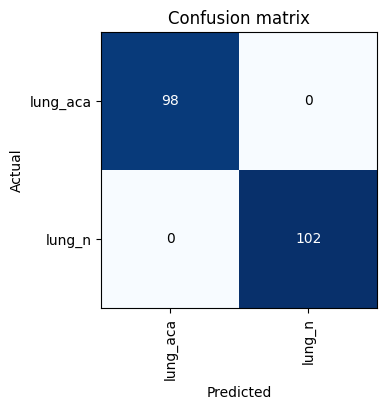

In [5]:
learn.fit_one_cycle(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,4), dpi=100)

In [ ]:
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

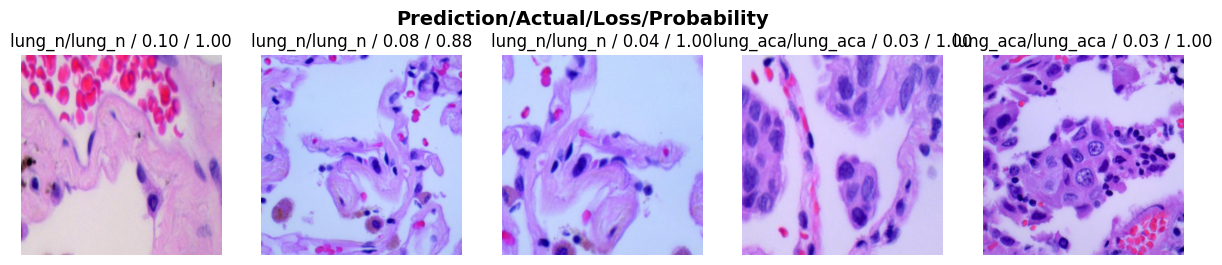

In [7]:
interp.plot_top_losses(5, nrows=1)

In [8]:
learn.export('model.pkl')